## 搭建一个简单的问答系统

本次项目的目标是搭建一个基于检索式的简单的问答系统。至于什么是检索式的问答系统请参考课程直播内容/PPT介绍。 

通过此项目，你将会有机会掌握以下几个知识点：
1. 字符串操作   2. 文本预处理技术（词过滤，标准化）   3. 文本的表示（tf-idf, word2vec)  4. 文本相似度计算  5. 文本高效检索

此项目需要的数据：
1. dev-v2.0.json: 这个数据包含了问题和答案的pair， 但是以JSON格式存在，需要编写parser来提取出里面的问题和答案。 
2. glove.6B: 这个文件需要从网上下载，下载地址为：https://nlp.stanford.edu/projects/glove/， 请使用d=100的词向量

##### 检索式的问答系统
问答系统所需要的数据已经提供，对于每一个问题都可以找得到相应的答案，所以可以理解为每一个样本数据是 <问题、答案>。 那系统的核心是当用户输入一个问题的时候，首先要找到跟这个问题最相近的已经存储在库里的问题，然后直接返回相应的答案即可。 举一个简单的例子：

假设我们的库里面已有存在以下几个<问题,答案>：
<"贪心学院主要做什么方面的业务？”， “他们主要做人工智能方面的教育”>
<“国内有哪些做人工智能教育的公司？”， “贪心学院”>
<"人工智能和机器学习的关系什么？", "其实机器学习是人工智能的一个范畴，很多人工智能的应用要基于机器学习的技术">
<"人工智能最核心的语言是什么？"， ”Python“>
.....

假设一个用户往系统中输入了问题 “贪心学院是做什么的？”， 那这时候系统先去匹配最相近的“已经存在库里的”问题。 那在这里很显然是 “贪心学院是做什么的”和“贪心学院主要做什么方面的业务？”是最相近的。 所以当我们定位到这个问题之后，直接返回它的答案 “他们主要做人工智能方面的教育”就可以了。 所以这里的核心问题可以归结为计算两个问句（query）之间的相似度。

在本次项目中，你会频繁地使用到sklearn这个机器学习库。具体安装请见：http://scikit-learn.org/stable/install.html  sklearn包含了各类机器学习算法和数据处理工具，包括本项目需要使用的词袋模型，均可以在sklearn工具包中找得到。 另外，本项目还需要用到分词工具jieba, 具体使用方法请见 https://github.com/fxsjy/jieba

### Part 2.1  第一部分： 读取文件，并把内容分别写到两个list里（一个list对应问题集，另一个list对应答案集）

In [2]:
import json
def read_corpus():
    """
    读取给定的语料库，并把问题列表和答案列表分别写入到 qlist, alist 里面。 在此过程中，不用对字符换做任何的处理（这部分需要在 Part 2.3里处理）
    qlist = ["问题1"， “问题2”， “问题3” ....]
    alist = ["答案1", "答案2", "答案3" ....]
    务必要让每一个问题和答案对应起来（即下标位置一致）
    """
    qlist = []
    alist = []
    with open('data/train-v2.0.json') as f:
        data_array = json.load(f)['data']
        for data in data_array:
            paragraphs = data['paragraphs']
            for paragraph in paragraphs:
                qas = paragraph['qas']
                for qa in qas:
                    if 'plausible_answers' in qa:
                        qlist.append(qa['question'])
                        alist.append(qa['plausible_answers'][0]['text'])
                    else:
                        qlist.append(qa['question'])
                        alist.append(qa['answers'][0]['text'])
                        
    assert len(qlist) == len(alist)  # 确保长度一样
    return qlist, alist

### Part 2.2 理解数据（可视化分析/统计信息）
对数据的理解是任何AI工作的第一步，需要充分对手上的数据有个更直观的理解。 

In [3]:
# 分数（10）
# TODO: 统计一下在qlist 总共出现了多少个单词？ 总共出现了多少个不同的单词？
#       这里需要做简单的分词，对于英文我们根据空格来分词即可，其他过滤暂不考虑（只需分词）
from collections import Counter


qlist , alist = read_corpus()

# 分词
def cut(input_list):
    list_new = []
    for q in input_list:
        list_new.append(q.replace('?','').split(' '))
    return list_new

qlist_new = [q for l in cut(qlist) for q in l]

dif_word_total = len(qlist_new)
word_dict = Counter(qlist_new)
word_total = len(dict(word_dict))
print ("一共出现了 %d 个单词"%dif_word_total)
print ("共有 %d 个不同的单词"%word_total)


一共出现了 1321965 个单词
共有 61885 个不同的单词


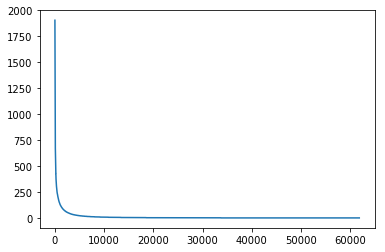

In [4]:
# TODO: 统计一下qlist中每个单词出现的频率，并把这些频率排一下序，然后画成plot. 比如总共出现了总共7个不同单词，而且每个单词出现的频率为 4, 5,10,2, 1, 1,1
#       把频率排序之后就可以得到(从大到小) 10, 5, 4, 2, 1, 1, 1. 然后把这7个数plot即可（从大到小）
#       需要使用matplotlib里的plot函数。y轴是词频
import matplotlib.pyplot as plt
y = []
for i in word_dict:
    y.append(word_dict[i])

plt.plot(sorted(y,reverse=True)[50:])
plt.show()



### 2.3 文本预处理
此部分需要尝试做文本的处理。在这里我们面对的是英文文本，所以任何对英文适合的技术都可以考虑进来。

In [ ]:
# 分数（10）

# TODO: 对于qlist, alist做文本预处理操作。 可以考虑以下几种操作：
#       1. 停用词过滤 （去网上搜一下 "english stop words list"，会出现很多包含停用词库的网页）   
#       2. 转换成lower_case： 这是一个基本的操作   
#       3. 去掉一些无用的符号： 比如连续的感叹号！！！， 或者一些奇怪的单词。
#       4. 去掉出现频率很低的词：比如出现次数少于10,20....
#       5. 对于数字的处理： 分词完只有有些单词可能就是数字比如44，415，把所有这些数字都看成是一个单词，这个新的单词我们可以定义为 "#number"
#       6. stemming（利用porter stemming): 因为是英文，所以stemming也是可以做的工作
#       7. 其他（如果有的话）
# #       请注意，不一定要按照上面的顺序来处理，具体处理的顺序思考一下，然后选择一个合理的顺序
import string
from nltk.stem.porter import PorterStemmer

# 低频词库
low_frequency_words = []
for (k,v) in  word_dict.items():
    if v < 2:
        low_frequency_words.append(k)
p = PorterStemmer()

def text_preprocessing(input_list):
    stop_words = ["a","able","about","across","after","all","almost","also","am","among","an","and","any","are","as","at","be","because","been","but","by","can","cannot","could","dear","did","do","does","either","else","ever","every","for","from","get","got","had","has","have","he","her","hers","him","his","how","however","i","if","in","into","is","it","its","just","least","let","like","likely","may","me","might","most","must","my","neither","no","nor","not","of","off","often","on","only","or","other","our","own","rather","said","say","says","she","should","since","so","some","than","that","the","their","them","then","there","these","they","this","tis","to","too","twas","us","wants","was","we","were","what","when","where","which","while","who","whom","why","will","with","would","yet","you","your","ain't","aren't","can't","could've","couldn't","didn't","doesn't","don't","hasn't","he'd","he'll","he's","how'd","how'll","how's","i'd","i'll","i'm","i've","isn't","it's","might've","mightn't","must've","mustn't","shan't","she'd","she'll","she's","should've","shouldn't","that'll","that's","there's","they'd","they'll","they're","they've","wasn't","we'd","we'll","we're","weren't","what'd","what's","when'd","when'll","when's","where'd","where'll","where's","who'd","who'll","who's","why'd","why'll","why's","won't","would've","wouldn't","you'd","you'll","you're","you've"]
    # 分词
    input_list = cut(input_list)    
    new_list = [] #保存处理完的qlist\alist
    for l in input_list:
        l_list = '' # 保存句子
        for word in l:
            # 转换小写/stemming
            word = p.stem(word)
            
            # 去除所有标点符号
            word = ''.join(c for c in word if c not in string.punctuation)
            
            # 处理数字
            if word.isdigit():
                word = word.replace(word,'#number')
            
            if word not in stop_words and word not in low_frequency_words:
                l_list += word + ' '
        new_list.append(l_list)
    return new_list
       
qlist = text_preprocessing(qlist)   # 更新后的


['beyonc start becom popular ']
['beyonc start becom popular ', 'area beyonc compet wa grow up ']
['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ']
['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ']
['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ']
['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ']
['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist 

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ']
['beyonc st

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music r

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.



['beyonc start becom popular ', 'area beyonc compet wa grow up ', 'beyonc leav destiny child becom solo singer ', 'In citi state beyonc  grow up  ', 'In decad beyonc becom famou ', 'In rb group wa lead singer ', 'album made worldwid known artist ', 'manag destiny child group ', 'beyoncé rise fame ', 'role beyoncé destiny child ', 'wa first album beyoncé releas solo artist ', 'beyoncé releas danger love ', 'mani grammi award beyoncé win first solo album ', 'wa beyoncé role destiny child ', 'wa name beyoncé first solo album ', 'second solo album entertain ventur beyonc explor ', 'artist beyonc marri ', 'To set record grammys mani beyonc win ', 'movi beyonc receiv  first golden globe nomin ', 'beyonc take hiatu career take control manag ', 'album wa darker tone previou work ', 'movi portray etta james beyonc creat sasha fierc ', 'destiny child end group act ', 'wa name beyoncé second solo album ', 'wa beyoncé first act job #number ', 'beyoncé marri ', 'name beyoncé alterego ', 'In music 

### 2.4 文本表示
当我们做完关键的预处理过程之后，就需要把每一个文本转换成向量。

In [6]:
# 分数（10）

# TODO: 把qlist中的每一个问题字符串转换成tf-idf向量, 转换之后的结果存储在X矩阵里。 X的大小是： N* D的矩阵。 这里N是问题的个数（样本个数），
#       D是字典库的大小。 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer() # 定一个tf-idf的vectorizer
X = vectorizer.fit_transform(qlist)   # 结果存放在X矩阵

In [ ]:
# TODO: 矩阵X有什么特点？ 计算一下它的稀疏度
X_list = [i for k in X.toarray() for i in k]
count_total = len(X_list)
count_zero = X_list.count(0)
sparsity = (count_total-count_zero)/count_total
print (sparsity)  # 打印出稀疏度

### 2.5 对于用户的输入问题，找到相似度最高的TOP5问题，并把5个潜在的答案做返回

In [7]:
# 分数（10）
from sklearn.metrics.pairwise import cosine_similarity
alist = np.array(alist)
def top5results(input_q):
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 对于用户的输入 input_q 首先做一系列的预处理，然后再转换成tf-idf向量（利用上面的vectorizer)
    2. 计算跟每个库里的问题之间的相似度
    3. 找出相似度最高的top5问题的答案
    """
    input_q = text_preprocessing([input_q])
    input_vec = vectorizer.transform(input_q)
    res = cosine_similarity(input_vec,X)[0]
    top_idxs = np.argsort(res)[-5:].tolist()  # top_idxs存放相似度最高的（存在qlist里的）问题的下标
    return alist[top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案    

NameError: name 'np' is not defined

In [11]:
# TODO: 编写几个测试用例，并输出结果
# print (top5results("what's your name"))
print (top5results("When did Beyonce start becom popular"))

['Middle Ages' 'As of the 2010s'
 'Particularly since the 1950s, pro wrestling events have frequently been responsible for sellout crowds at large arenas'
 'Paris' 'in the late 1990s']


In [13]:
# 分数（5）

# TODO: 上面的top5results算法的时间复杂度和空间复杂度分别是多少？

# 时间复杂度 = O(nlogn)， 空间复杂度 = O(n)

### 2.6 利用倒排表的优化。 
上面的算法，一个最大的缺点是每一个用户问题都需要跟库里的所有的问题都计算相似度。假设我们库里的问题非常多，这将是效率非常低的方法。 这里面一个方案是通过倒排表的方式，先从库里面找到跟当前的输入类似的问题描述。然后针对于这些candidates问题再做余弦相似度的计算。这样会节省大量的时间。

In [16]:
inverted_idx = {}  # 定一个一个简单的倒排表

# 将关键词添加到倒排表中
for key,value in word_dict.items():
    if value >100 and value <1000:
        inverted_idx[key]=[]
        
# 在倒排表中添加关键词存在于qlist中的索引
keywords_index = 0
for q in cut(qlist):
    for word in q:
        if word in inverted_idx.keys():
            inverted_idx[word].append(keywords_index)
    keywords_index += 1


In [17]:
# 分数（10）

# TODO: 基于倒排表的优化。在这里，我们可以定义一个类似于hash_map, 比如 inverted_index = {}， 然后存放包含每一个关键词的文档出现在了什么位置，
#       也就是，通过关键词的搜索首先来判断包含这些关键词的文档（比如出现至少一个），然后对于candidates问题做相似度比较。
# 

def top5results_invidx(input_q):
    # 从倒排表中取出相关联的索引
    index_list = []
    for c in cut([input_q]):
        for i in c:
            if i in inverted_idx.keys():
                index_list += inverted_idx[i]
    index_list = list(set(index_list))
    
    input_q = text_preprocessing([input_q])
    input_vec = vectorizer.transform(input_q)
    res = cosine_similarity(input_vec,X[index_list])[0]
    top_idxs = np.argsort(res)[-5:].tolist()  # top_idxs存放相似度最高的（存在qlist里的）问题的下标
    
    return alist[top_idxs] 

In [18]:
# TODO: 编写几个测试用例，并输出结果
print (top5results_invidx("When did Beyonce start becom popular"))
# print (top5results_invidx(""))

['Britney Spears, Pink, and Enrique Iglesias' 'formidable'
 'Richard Taruskin' 'concert étude' 'in the late 1990s']


In [23]:
# 分数（3）

# TODO: 上面的top5results算法的时间复杂度和空间复杂度分别是多少？

# 时间复杂度 = O(nlogn)， 空间复杂度 = O(n)

### 2.7 基于词向量的文本表示
上面所用到的方法论是基于词袋模型（bag-of-words model）。这样的方法论有两个主要的问题：1. 无法计算词语之间的相似度  2. 稀疏度很高。 在2.7里面我们
讲采用词向量作为文本的表示。词向量方面需要下载： https://nlp.stanford.edu/projects/glove/ （请下载glove.6B.zip），并使用d=100的词向量（100维）。


In [20]:
# 建立glove矩阵
with open('data/glove.6B.100d.txt', 'r') as file1:
    emb = []
    vocab = []
    for line in file1.readlines():
        row = line.strip().replace("?",'').split(' ')
        vocab.append(row[0])
        emb.append(row[1:])
emb =np.asarray(emb) # 读取每一个单词的嵌入。这个是 D*H的矩阵，这里的D是词典库的大小， H是词向量的大小。 这里面我们给定的每个单词的词向量，那句子向量怎么表达？
      # 其中，最简单的方式 句子向量 = 词向量的平均（出现在问句里的）， 如果给定的词没有出现在词典库里，则忽略掉这个词。

In [25]:
# 获取句子的vec值
def get_words_vec(words):
    glove_index_list = []
    # 取句子对应单词的索引
    for word in words.split(' '):
        if word in vocab:
            index = vocab.index(word)
            glove_index_list.append(index)
    return emb[glove_index_list].astype(float).sum()/len(words.split(' '))

In [26]:
# 将qlist转换为句子向量
qlist_matrix = []
for q in qlist:
    q_vec = get_words_vec(q)
    qlist_matrix.append(q_vec)

In [ ]:
qlist_matrix = np.asarray(qlist_matrix)

In [64]:
# 分数（15）

def top5results_emb(input_q):
    """
    给定用户输入的问题 input_q, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 利用倒排表来筛选 candidate
    2. 对于用户的输入 input_q，转换成句子向量
    3. 计算跟每个库里的问题之间的相似度
    4. 找出相似度最高的top5问题的答案
    """
    
    abs_v = abs(qlist_matrix[0])
    # 存储所有返回结果的索引
    res = []
    # 从倒排表中取出相关联的索引
    index_list = []
    for c in cut([input_q]):
        for i in c:
            if i in inverted_idx.keys():
                index_list += inverted_idx[i]
    index_list = list(set(index_list))
    # input_q的vec值
    input_q_vec = get_words_vec(input_q)
    # 遍历倒排表内所有值，将list中所有vec值与input_q的vec值做对比，绝对值差较小的数的索引存入res中
    for value in qlist_matrix[index_list]:
        if abs(input_q_vec-value) < abs_v:
            abs_v = abs(input_q_vec-value)
            res.append(qlist_matrix[index_list].tolist().index(value))
    
    top_indx = np.argsort(res)[-5:].tolist()
    
    return alist[top_indx]
    
    


In [65]:
# TODO: 编写几个测试用例，并输出结果
print (top5results_emb("When did Beyonce start becom popular"))
# print (top5results_emb("who you are"))

# 我们在验收作业时在后台会建立几个测试用例，来验证返回的准确性。

['singing and dancing' '2003' 'Houston, Texas' 'late 1990s'
 "Destiny's Child"]
